In [160]:
"""LiuKatrina_02.ipynb Harvard MCB 112 Problem Set 02: the adventure of the ten Arcs submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Sep 18, 2022"

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exercise 1 Reproduction of Moriarty's Results with Kallisto
First, we check the working version of kallisto on the server.

In [162]:
! kallisto # Show current working version of kallisto

kallisto 0.46.1

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>



Next, we prepare an index file from the transcriptomes in arc.fasta.gz.

In [163]:
! kallisto index -i arc.idx arc.fasta.gz # Build the index of transcriptomes


[build] loading fasta file arc.fasta.gz
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 



We are then able to analyze the reads in the provided fastq file arc.fastq.gz.

In [164]:
# Analyze in single ended-mode with the provided arguments
! kallisto quant -i arc.idx -o output --single -l 150 -s 20 arc.fastq.gz 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: arc.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 99,981 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 81 rounds



Finally, we have obtained the resulting abundance levels in the output, whose tpm levels are very similar to the TPM provided by Moriary.

In [165]:
data = pd.read_csv ("output/abundance.tsv", sep = '\t')
print("Output abundance information:")
print(data)

Output abundance information:
  target_id  length  eff_length  est_counts       tpm
0      Arc1    4000        3851     2781.96   20318.9
1      Arc2    2000        1851     3585.12   54477.8
2      Arc3    3000        2851    28613.50  282290.0
3      Arc4    4000        3851    10412.40   76050.3
4      Arc5    4000        3851    13042.90   95263.0
5      Arc6    3000        2851     1195.26   11792.0
6      Arc7    2000        1851     5864.45   89113.5
7      Arc8    2000        1851     5717.54   86881.2
8      Arc9    3000        2851     2909.53   28704.4
9     Arc10    3000        2851    25858.30  255109.0


# Exercise 2
## Part a: Similate Arc transcriptome and RNA-seq reads in a simple way

Before the simulation functions, we want to setup the parameters used in this step.

In [166]:
# Set up the Arc locus 
# Parameters given by pset02 writeup
S         = 10           # Number of segments in the Arc locus (A..J)
T         = S            # Number of different transcripts (the same, one starting on each segment, 1..10)
N         = 100000       # total number of observed reads we generate
len_S     = 1000         # length of each segment (nucleotides)
len_Arc   = len_S * S    # total length of the Arc locus (nucleotides)
len_R     = 75           # read length
# Lengths of each transcripts
transcripts_lens = [4000,2000,3000,4000,4000,3000,2000,2000,3000,3000] 
# Abundance levels of each transcripts
transcripts_abds = [0.008,0.039,0.291,0.112,0.127,0.008,0.059,0.060,0.022,
                    0.273] 
transcripts_norm_abds = np.array(transcripts_abds)/sum(transcripts_abds)

We then create the following methods to be used to generate random DNA sequences, creating transcripts from the generated DNA, and generate reads based on the transcripts.

In [167]:
def generate_dna(total_len, nuc_list = ['A','G','T','C'],
                 nuc_prob = [0.25,0.25,0.25,0.25]):
    """ Generate a random DNA string based on the provided list of bases and
    list of probability of base appearences
    :param total_len: the length of the DNA to be generated
    :param nuc_list: the list of chars of the nucleotide bases
    :param nuc_prob: the list of floats representing the weight/probability
                    of the appearences of each bases
    :return: a string of randomly generated DNA string
    """
    result_dna = np.random.choice(nuc_list, total_len, p=nuc_prob)
    return ''.join(result_dna)


def generate_transcriptome(dna,seg_len, tr_lens):
    """ Generate a list of transcripts of the given lengths based on the DNA,
    each taking a different starting coordinate at the beginning of each 
    segment in the DNA. 
    :param dna: a string of provided DNA
    :param seg_len: a number denoting the length of segment in DNA
    :param tr_lens: a list of numbers each denoting the length of transcripts
    :return: a list of string transcripts created from the template dna
    """
    transcripts = []
    for i in range(len(tr_lens)):
        tr_len = tr_lens[i]
        # Computing the starting position of the transcript
        seg_start = i * seg_len 
        transcript = dna[seg_start:seg_start+tr_len]
        # Considering circular permutaion
        if seg_start+tr_len >= len(dna):
            transcript += dna[:seg_start+tr_len-len(dna)]
        transcripts.append(transcript)
    return transcripts


def write_transcript_fasta(transcripts,names, output_file, line_len=80):
    """ Write the generated transcripts to a fasta file
    :param transcripts: a list of string representation of transcripts
    :param names: a list of strings of transcript names
    :param output_file: a string of output file names
    :param line_len: an integer of how many bases to be included in each line
    """
    f = open(output_file, "w")
    for i in range(len(transcripts)):
        f.write(">"+names[i]+"\n")
        for idx in range(0,len(transcripts[i]),line_len):
            f.write(transcripts[i][idx:idx+line_len]+"\n")
    f.close()
            
        
def generate_read(transcripts, transcript_names, abundances, read_len, 
                  read_num):
    """ Generate read_num many reads based on the given transcripts, 
    abundances, and length of reads. First, sample a transcript by abundance
    levels. Then, sample a starting point by the effective length.
    :param transcripts: a list of string rerpesentation of transcripts
    :param transcript_names: a list of strings of names of transcripts
    :param abundances: a list of floats each representing the abundance 
                        levels of each transcripts
    :param read_len: the length of reads to be generated
    :param read_num: the number of reads to be generated
    :return reads: a list of strings representing each generated reads
    :return read_names: a list of strings of names of each generated read
    """
    reads = []
    read_names = []
    # Sample a list of indices of which transcripts the read takes from.
    sample_transcripts = np.random.choice(len(transcripts),read_num, 
                                          p=abundances)
    for i in range(len(sample_transcripts)):
        sti = sample_transcripts[i]
        # Possible starting position
        eff_len = len(transcripts[sti])-read_len+1 
        sample_start = np.random.choice(eff_len)
        sample_read = transcripts[sti][sample_start:sample_start+read_len]
        reads.append(sample_read)
        read_names.append("%d:%s:%d:%d"%(i+1, transcript_names[sti], 
                                         sample_start, read_len))
    return reads, read_names
        
        
def write_read_fastq(reads,read_names,output_file):
    """ Write reads to a fastq formed file
    :param reads: a list of strings each representing a read
    :param read_names: a list of strings each representing the corresponding
                        read name
    :param output_file: a string of the output file name
    """
    f = open(output_file, "w")
    for i in range(len(reads)):
        f.write("@"+read_names[i]+"\n")
        f.write(reads[i]+"\n")
        f.write("+\n")
        f.write("I"*len(reads[i])+"\n")
    f.close()
    

After the methods are being created, we apply them to store the transcripts in the 'generated.fasta' file and store the generated reads in the 'generated.fastq' file.

In [168]:
sim_dna = generate_dna(len_Arc)
trans = generate_transcriptome(sim_dna, len_S, transcripts_lens)
tr_names = ["Arc"+chr(ord('A')+i) for i in range(S)]
write_transcript_fasta(trans,tr_names,"generated.fasta")
rs, rns = generate_read(trans,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"generated.fastq")

## Part b: alternative version
We then try to implement a better version, a more realistic version, to simulate the results by taking into account of different factors.

In [169]:
# Additional parameter settings obtained from pset02 writeup
alpha     = 0.999        # base calling accuracy (Q30 bases, typical of current Illumina)
mean_frag = 150          # fragment size: mean (of a truncated Gaussian)
sd_frag   = 20           # fragment size: stdev

To achieve better simulation of creating reads, we need a couple of helper functions to achieve this goal, which includes computing the reverse complement of a DNA sequence, generate_read_bca, and a truncated Gaussian sampler.

In [170]:
def reverse_complement(dna_seq):
    """ Computing the reverse complement of a input DNA sequence
    :param dna_seq: a string representation of the input DNA sequence
    :return: the reverse complement of the input sequence
    """
    rc = ""
    for base in dna_seq:
        if base == 'A':
            rc = 'T'+rc
        elif base == 'T':
            rc = 'A'+rc
        elif base == 'G':
            rc = 'C'+rc
        elif base == 'C':
            rc = 'G'+rc
        else:
            print("Invalid input DNA sequence with invalid base", base)
            return None
    return rc


def generate_read_bca(temp_dna, base_call_acc=0.999):
    """ Generate a read based on the template read and also the provided base
    call accuracy. We sample each base identical to the template read by 
    probability of the base call accuracy and each of the different bases by
    the probability of (1-base call accuray)/3
    :param temp_dna: a string representing the template DNA
    :param base_call_acc: a float in [0,1] representing the probability of
                            correctly generate the base.
    :return: a string representing the sampled DNA with base calling error
    """
    result_dna = ""
    base_list = ['A','T','G','C']
    for base in temp_dna:
        base_weight = [base_call_acc if b == base else (1-base_call_acc)/3 for b in base_list]
        result_base = np.random.choice(base_list,p=base_weight)
        result_dna += result_base
    return result_dna
     

def truncated_gaussian(m,sd,low,high):
    """ Sampling a gaussian distribution between the low and high with mean
    m and standard deviation sd
    :param m: a float representing the mean
    :param sd: a float representing the standard deviation
    :param low: an integer of the lowest value that can be sampled
    :param high: an integer of the highest value that can be sampled
    :return: an integer sampled by the truncated gaussian distribution.
    """
    while True:
        fraglen = int(np.random.normal(m, sd))
        if fraglen >= low: break
    if fraglen > high: fraglen = high
    return fraglen


def generate_read_better_sim(transcripts, transcript_names, abundances, 
                      read_len, read_num, frag_len_mean=150, frag_len_sd=20, 
                      read_orient_rand=True, base_call_acc=0.999):
    """ Generate reads with better simulations with more complicated factors.
    :param transcripts: a list of string rerpesentation of transcripts
    :param transcript_names: a list of strings of names of transcripts
    :param abundances: a list of floats each representing the abundance 
                        levels of each transcripts
    :param read_len: the length of reads to be generated
    :param read_num: the number of reads to be generated
    :param frag_len_mean: an integer of the mean of generated fragment lengths
    :param frag_len_sd: an integer of the standard deviation of generated
                        fragment lengths
    :param read_orient_rand: a boolean value indicating whether to sample a
                                random value determining the read's orient
    :param base_call_acc: a float representing the base call accuracy
    :return reads: a list of strings representing each generated reads
    :return read_names: a list of strings of names of each generated read
    """
    reads = []
    read_names = []
    # Sample a list of indices of which transcripts the read takes from.
    sample_transcripts = np.random.choice(len(transcripts),read_num, 
                                          p=abundances)
    for i in range(read_num):
        sti = sample_transcripts[i]
        # Calculate the sample fragment length based on a truncated gaussian
        # distribution
        fraglen = truncated_gaussian(frag_len_mean,frag_len_sd,read_len,
                                     len(transcripts[sti]))
        eff_len = len(transcripts[sti])-fraglen+1
        sample_start = np.random.choice(eff_len)
        sample_read = transcripts[sti][sample_start:sample_start+fraglen]
        if read_orient_rand:
            read_orient = np.random.choice(2)
        else:
            read_orient = 0
        # Determine which orientation the read takes
        if read_orient == 0:
            sim_read_temp = sample_read[:read_len]
        else:
            sim_read_temp = reverse_complement(sample_read)[:read_len]
        # Generate the read based on the template read and the base calling
        # error
        sim_read = generate_read_bca(sim_read_temp,base_call_acc)
        read_name = "%d:%s:%d:%d"%(i+1, transcript_names[sti],sample_start,
                                   read_len)
        reads.append(sim_read)
        read_names.append(read_name)
    return reads, read_names


Then, we apply the better simulation function to generate the reads, and we store the reads in a fastq file named 'generated_better_sim.fastq'.

In [171]:
rds, rdlens = generate_read_better_sim(trans,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"generated_better_sim.fastq")

# Exercise 3 Testing Kallisto
To test kallisto, first we need to run it with our simulated data.

In [172]:
!kallisto index -i generated.idx generated.fasta # Generate the index file


[build] loading fasta file generated.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 



In [173]:
# Analyze the simple simulated data
!kallisto quant -i generated.idx -o generated_output --single -l 75 -s 10 generated.fastq


[quant] fragment length distribution is truncated gaussian with mean = 75, sd = 10
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: generated.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 100,000 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 86 rounds



In [174]:
# Analyze the better version of the simulated data
!kallisto quant -i generated.idx -o generated_better_sim_output --single -l 150 -s 20 generated_better_sim.fastq 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: generated_better_sim.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 100,000 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 369 rounds



To compare the results, we need to look at what the TPM are supposed to be looking like based the abundance levels we used for simulation.

In [175]:
def tpm_from_abd(abundances,transcript_lens):
    """ Calculate the transcript abundances in TPM units based on the
    nucleotide abundance levels.
    :param abundances: a list of floats between 0 and 1 representing the
                        nucleotide abundance levels of each transcript
    :param transcript_lens: a list of integers representing the length of
                            each transcript
    :return: a list of transcript abundances in unit TPM
    """
    normed_vals = []
    for i in range(len(abundances)):
        normed_vals.append(abundances[i]/transcript_lens[i])
    return np.array(normed_vals)*1000000/sum(normed_vals)

Run the method on the nucleotide abundance levels we used to generate the simulated data and we get the TPMs:

In [176]:
# Compute the expected tpm
exp_tpm = tpm_from_abd(transcripts_norm_abds, transcripts_lens)
print(exp_tpm)

[  5904.05904059  57564.57564576 286346.86346863  82656.82656827
  93726.93726937   7872.07872079  87084.87084871  88560.88560886
  21648.21648216 268634.68634686]


However, the resulting tpms of kallisto looks like the following, which are very different the expected tpms and incorrect. Even though from the figure, we can see a similar trend between the simulated tpms and expected tpm, but differences between smaller tpm values were erased by the scale of y axis. Looking at the data frames, the differences are actually noticeable.

In [177]:
# Load simple simulation results
simple_data = pd.read_csv ("generated_output/abundance.tsv", sep = '\t')
simple_data

,target_id,length,eff_length,est_counts,tpm
0,ArcA,4000,3926,1667.12,12260.5
1,ArcB,2000,1926,3434.10,51481.0
2,ArcC,3000,2926,29131.20,287459.0
3,ArcD,4000,3926,10264.50,75488.1
4,ArcE,4000,3926,12928.50,95080.0
5,ArcF,3000,2926,1638.29,16166.2
6,ArcG,2000,1926,5558.10,83322.3
7,ArcH,2000,1926,5785.39,86729.6
8,ArcI,3000,2926,2715.27,26793.5
9,ArcJ,3000,2926,26877.50,265220.0


In [178]:
# Load better simulated results
better_data = pd.read_csv ("generated_better_sim_output/abundance.tsv", sep = '\t')
better_data

,target_id,length,eff_length,est_counts,tpm
0,ArcA,4000,3851,4087.990000,30056.000000
1,ArcB,2000,1851,5636.790000,86222.400000
2,ArcC,3000,2851,25042.800000,248703.000000
3,ArcD,4000,3851,11493.100000,84500.400000
4,ArcE,4000,3851,15631.800000,114929.000000
5,ArcF,3000,2851,0.009538,0.094719
6,ArcG,2000,1851,4837.940000,74002.900000
7,ArcH,2000,1851,5812.010000,88902.700000
8,ArcI,3000,2851,4431.780000,44012.500000
9,ArcJ,3000,2851,23025.700000,228671.000000


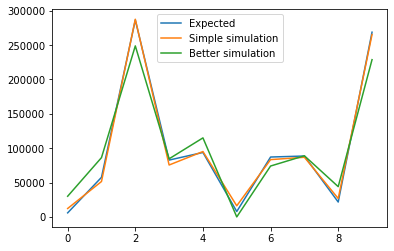

In [179]:
# Plot the simulated tpms with the expected tpms
plt.figure()
plt.plot(range(10), exp_tpm, label="Expected")
plt.plot(range(10), simple_data["tpm"], label="Simple simulation")
plt.plot(range(10), better_data["tpm"], label="Better simulation")
plt.legend()
plt.show()

# Exercise 4 Debugging Kallisto
To figure out what is happening with kallisto, we will experiment with different values of the transcript lengths and abundance levels. We will first generate the DNA to be used for all experiments.

In [180]:
test_dna = sim_dna
# Fixed variable
tr_names = ["Arc"+chr(ord('A')+i) for i in range(S)]

## 1. Controlling the abundance levels

In the first experiment, we will control the abundance level to be the one provided from the write up and used in previous simulations. We tests with different transcript lengths.

In [181]:
# Test lengths of transcripts
test_lens_0 = [2000]*10
test_lens_1 = [4000]*10

# Genearate reads for test 0
trans_0 = generate_transcriptome(test_dna, len_S, test_lens_0)
write_transcript_fasta(trans_0,tr_names,"test_generated_0.fasta")
rs, rns = generate_read(trans_0,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_0.fastq")

# Generate reads for test 1
trans_1 = generate_transcriptome(test_dna, len_S, test_lens_1)
write_transcript_fasta(trans_1,tr_names,"test_generated_1.fasta")
rs, rns = generate_read(trans_1,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_1.fastq")

Then, we run kallisto with the generated test reads.

In [182]:
# Run kallisto for test 0
!kallisto index -i test_0.idx test_generated_0.fasta
!kallisto quant -i test_0.idx -o test_0_output --single -l 75 -s 10 test_generated_0.fastq

# Run kallisto for test 1
!kallisto index -i test_1.idx test_generated_1.fasta
!kallisto quant -i test_1.idx -o test_1_output --single -l 75 -s 10 test_generated_1.fastq



[build] loading fasta file test_generated_0.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 21 contigs and contains 10000 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 75, sd = 10
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 20
[quant] running in single-end mode
[quant] will process file 1: test_generated_0.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 100,000 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds


[build] loading fasta file test_generated_1.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence 

In [183]:
# Reading test results and compute expected tpms
test_0_result = pd.read_csv("test_0_output/abundance.tsv", sep = '\t')
exp_0 = tpm_from_abd(transcripts_norm_abds,test_lens_0)
test_1_result = pd.read_csv("test_1_output/abundance.tsv", sep = '\t')
exp_1 = tpm_from_abd(transcripts_norm_abds,test_lens_1)

In [184]:
# Display the results of test 0
test_0_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 0 TPM":test_0_result["tpm"], "Expected Test 0 TPM":exp_0})
test_0_df

,Transcript name,Result Test 0 TPM,Expected Test 0 TPM
0,ArcA,11591.10,8008.008008
1,ArcB,36289.90,39039.039039
2,ArcC,292932.00,291291.291291
3,ArcD,115145.00,112112.112112
4,ArcE,125482.00,127127.127127
5,ArcF,7601.78,8008.008008
6,ArcG,57185.90,59059.059059
7,ArcH,61084.70,60060.060060
8,ArcI,20906.60,22022.022022
9,ArcJ,271780.00,273273.273273


In [185]:
# Display the results of test 1
test_1_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 1 TPM":test_1_result["tpm"], "Expected Test 1 TPM":exp_1})
test_1_df

,Transcript name,Result Test 1 TPM,Expected Test 1 TPM
0,ArcA,19742.2,8008.008008
1,ArcB,37058.5,39039.039039
2,ArcC,285935.0,291291.291291
3,ArcD,111840.0,112112.112112
4,ArcE,131848.0,127127.127127
5,ArcF,15308.1,8008.008008
6,ArcG,51377.8,59059.059059
7,ArcH,54779.1,60060.060060
8,ArcI,27966.3,22022.022022
9,ArcJ,264145.0,273273.273273


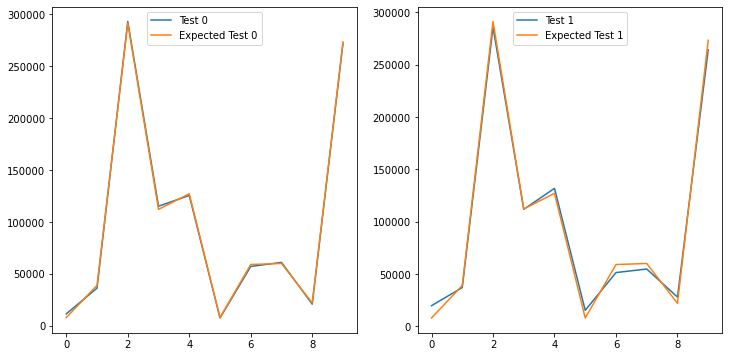

In [186]:
# Plotting the resulting tpms and expected tpms
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(10), test_0_result["tpm"], label="Test 0")
plt.plot(range(10), exp_0, label="Expected Test 0")
plt.legend()
plt.subplot(122)
plt.plot(range(10), test_1_result["tpm"], label="Test 1")
plt.plot(range(10), exp_1, label="Expected Test 1")
plt.legend()
plt.show()

From the data frames we can see that, the tpms generated from two tests align well with the expected tpm while the simple and better simulations. The produced figures does not show much information as the scale of y axis minmized the difference of smaller tpms. Then, considering how I build up the test dataset, where all transcripts length are being set to the same, I suspect that the difference in transcript lengths might be a factor affecting the tpms. Also, I noticed that with longer transcript length(4000nt), the resulting tpm differs more with the expected tpm comparing to the difference with shorter transcript length (2000nt).

## 2. Experiment with transcripts with different lengths

Based on our previous analysis, I designed several testing lists of transcript lengths with different values to see if this would actually impact the acccuracy of tpm.

In [187]:
# Test lengths of transcripts with different values
test_2 = [3000,2000,2000,2000,2000,2000,2000,2000,2000,2000]
test_3 = [4000,2000,2000,2000,2000,2000,2000,2000,2000,2000]
test_4 = [4000,4000,2000,2000,2000,2000,2000,2000,2000,2000]

After building test lists of transcript lengths, we conduct similar procedures with the previous experiment.

In [188]:
# Genearate reads for test 2
trans_2 = generate_transcriptome(test_dna, len_S, test_2)
write_transcript_fasta(trans_2,tr_names,"test_generated_2.fasta")
rs, rns = generate_read(trans_2,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_2.fastq")

# Generate reads for test 3
trans_3 = generate_transcriptome(test_dna, len_S, test_3)
write_transcript_fasta(trans_3,tr_names,"test_generated_3.fasta")
rs, rns = generate_read(trans_3,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_3.fastq")

# Generate reads for test 4
trans_4 = generate_transcriptome(test_dna, len_S, test_4)
write_transcript_fasta(trans_4,tr_names,"test_generated_4.fasta")
rs, rns = generate_read(trans_4,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_4.fastq")

In [189]:
# Run kallisto for test 2
!kallisto index -i test_2.idx test_generated_2.fasta
!kallisto quant -i test_2.idx -o test_2_output --single -l 75 -s 10 test_generated_2.fastq

# Run kallisto for test 3
!kallisto index -i test_3.idx test_generated_3.fasta
!kallisto quant -i test_3.idx -o test_3_output --single -l 75 -s 10 test_generated_3.fastq

# Run kallisto for test 4
!kallisto index -i test_4.idx test_generated_4.fasta
!kallisto quant -i test_4.idx -o test_4_output --single -l 75 -s 10 test_generated_4.fastq



[build] loading fasta file test_generated_2.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 20 contigs and contains 10000 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 75, sd = 10
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 20
[quant] running in single-end mode
[quant] will process file 1: test_generated_2.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 100,000 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds


[build] loading fasta file test_generated_3.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence 

In [190]:
# Reading test results and compute expected tpms
test_2_result = pd.read_csv("test_2_output/abundance.tsv", sep = '\t')
exp_2 = tpm_from_abd(transcripts_norm_abds,test_2)
test_3_result = pd.read_csv("test_3_output/abundance.tsv", sep = '\t')
exp_3 = tpm_from_abd(transcripts_norm_abds,test_3)
test_4_result = pd.read_csv("test_4_output/abundance.tsv", sep = '\t')
exp_4 = tpm_from_abd(transcripts_norm_abds,test_4)

In [191]:
# Display the results of test 2
test_2_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 2 TPM":test_2_result["tpm"], "Expected Test 2 TPM":exp_2})
test_2_df

,Transcript name,Result Test 2 TPM,Expected Test 2 TPM
0,ArcA,16993.80,5352.960856
1,ArcB,26816.90,39143.526263
2,ArcC,293860.00,292070.926731
3,ArcD,113966.00,112412.177986
4,ArcE,127977.00,127467.380395
5,ArcF,8610.93,8029.441285
6,ArcG,58362.20,59217.129475
7,ArcH,59160.00,60220.809635
8,ArcI,25113.80,22080.963533
9,ArcJ,269139.00,274004.683841


In [192]:
# Display the results of test 3
test_3_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 3 TPM":test_3_result["tpm"], "Expected Test 3 TPM":exp_3})
test_3_df

,Transcript name,Result Test 3 TPM,Expected Test 3 TPM
0,ArcA,11383.40,4020.100503
1,ArcB,33528.70,39195.979899
2,ArcC,290000.00,292462.311558
3,ArcD,112668.00,112562.814070
4,ArcE,128370.00,127638.190955
5,ArcF,8310.32,8040.201005
6,ArcG,60951.80,59296.482412
7,ArcH,59039.90,60301.507538
8,ArcI,25017.50,22110.552764
9,ArcJ,270730.00,274371.859296


In [193]:
# Display the results of test 4
test_4_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 4 TPM":test_4_result["tpm"], "Expected Test 4 TPM":exp_4})
test_4_df

,Transcript name,Result Test 4 TPM,Expected Test 4 TPM
0,ArcA,8904.14,4100.461302
1,ArcB,15101.10,19989.748847
2,ArcC,292417.00,298308.559713
3,ArcD,121754.00,114812.916453
4,ArcE,127884.00,130189.646335
5,ArcF,9706.38,8200.922604
6,ArcG,58888.40,60481.804203
7,ArcH,64265.00,61506.919528
8,ArcI,24302.80,22552.537160
9,ArcJ,276776.00,279856.483854


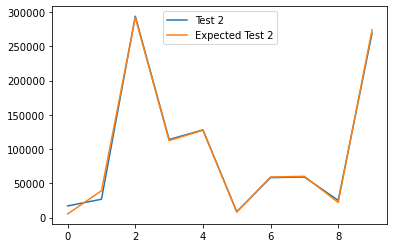

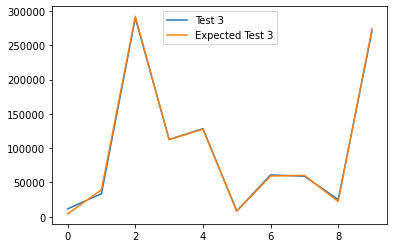

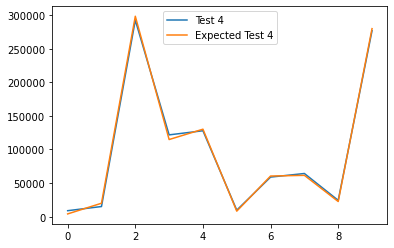

In [194]:
# Plotting the resulting tpms and expected tpms
plt.figure()
plt.plot(range(10), test_2_result["tpm"], label="Test 2")
plt.plot(range(10), exp_2, label="Expected Test 2")
plt.legend()
plt.show()
plt.figure()
plt.plot(range(10), test_3_result["tpm"], label="Test 3")
plt.plot(range(10), exp_3, label="Expected Test 3")
plt.legend()
plt.show()
plt.figure()
plt.plot(range(10), test_4_result["tpm"], label="Test 4")
plt.plot(range(10), exp_4, label="Expected Test 4")
plt.legend()
plt.show()

Comparing between test 0 and 2, we see that increasing the length of transcript 0 results in a difference in tpm produced and expected for transcript 0 and 1. Similarly comparing test 0 and test 3, we found the same discovery. Looking at the test 3 and test 4, we see differences of tpms of transcript 0, 1, and 3. Therefore, I wonder that maybe the difference of tpms is not of underlying reason of the difference in expected tpm and produced tpm, but rather the overlapping of the transcripts, which kallisto did not take into account, produces a larger difference in distribution of the times each DNA segment were being considered as a template for reads, and therefore messed up the abundance levels. To test this assumption, I designed one final experiment with non-overlapping reads which produces a distribution corresponding to the abundance levels of how many times the segment were being considered as read template.

## 3. Non-overlapping transcripts

The most straight forward one would just be the 1000 for each transcript length.


[build] loading fasta file test_generated_5.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 10 contigs and contains 9700 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 75, sd = 10
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 9,700
[index] number of equivalence classes: 10
[quant] running in single-end mode
[quant] will process file 1: test_generated_5.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 99,898 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds

  Transcript name  Result Test 5 TPM  Expected Test 5 TPM
0            ArcA            8008.17          8008.008008
1            ArcB           38479.20         39039.039039
2            ArcC  

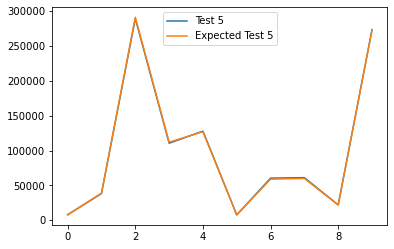

In [195]:
# Transcript lengths of test 5
test_5 = [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]


# Genearate reads for test 5
trans_5 = generate_transcriptome(test_dna, len_S, test_5)
write_transcript_fasta(trans_5,tr_names,"test_generated_5.fasta")
rs, rns = generate_read(trans_5,tr_names,transcripts_norm_abds,len_R, N)
write_read_fastq(rs,rns,"test_generated_5.fastq")


# Run kallisto for test 5
!kallisto index -i test_5.idx test_generated_5.fasta
!kallisto quant -i test_5.idx -o test_5_output --single -l 75 -s 10 test_generated_5.fastq


# Reading test results and compute expected tpms
test_5_result = pd.read_csv("test_5_output/abundance.tsv", sep = '\t')
exp_5 = tpm_from_abd(transcripts_norm_abds,test_5)


# Display the results of test 5
test_5_df = pd.DataFrame({"Transcript name":tr_names, "Result Test 5 TPM":test_5_result["tpm"], "Expected Test 5 TPM":exp_5})
print(test_5_df)


# Plotting the resulting tpms and expected tpms
plt.figure()
plt.plot(range(10), test_5_result["tpm"], label="Test 5")
plt.plot(range(10), exp_5, label="Expected Test 5")
plt.legend()
plt.show()

We see that with minimal overlapping of the transcripts, kallisto produces the correct results.